# import libraries

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import cv2
from tensorflow.keras.models import load_model
import numpy as np
from matplotlib import pyplot as plt

# . Load Data

In [2]:
data = tf.keras.utils.image_dataset_from_directory('data',color_mode='grayscale')

Found 2501 files belonging to 2 classes.


In [3]:
data_iterator = data.as_numpy_iterator()

In [4]:
batch = data_iterator.next()

In [5]:
batch[0].shape

(32, 256, 256, 1)

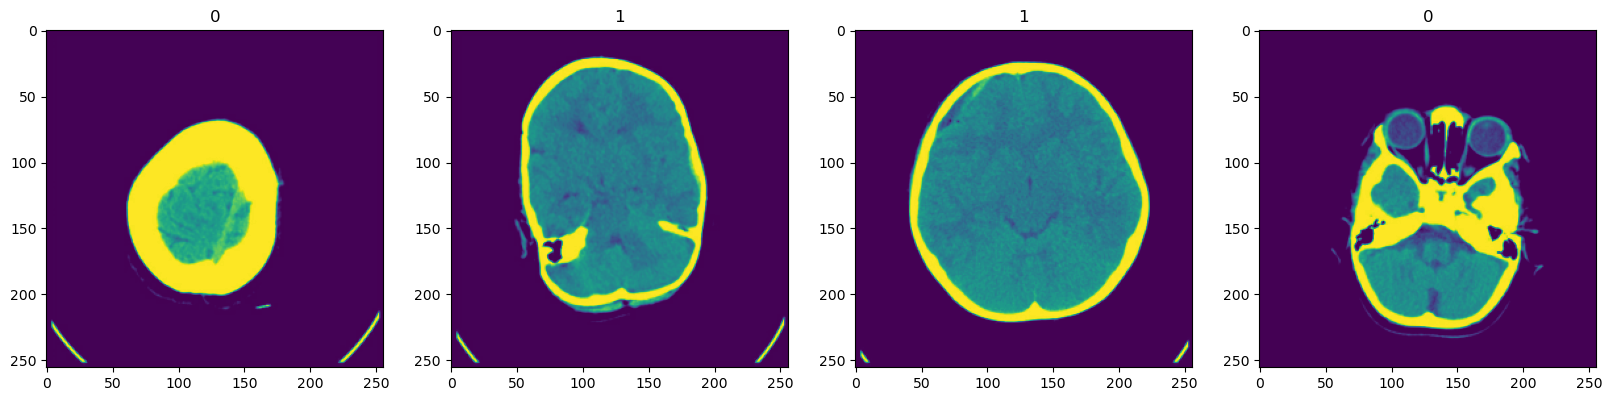

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [7]:
# data = data.map(lambda x,y: (x/255, y))

In [8]:
# data.as_numpy_iterator().next()

# 5. Split Data

In [9]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [10]:
train_size

55

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [12]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [17]:
logdir='logs'

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [19]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
55/55 [==============================] - 23s 412ms/step - loss: 12.1923 - accuracy: 0.8420 - val_loss: 0.2578 - val_accuracy: 0.9104
Epoch 2/20
55/55 [==============================] - 23s 422ms/step - loss: 0.1864 - accuracy: 0.9267 - val_loss: 0.1890 - val_accuracy: 0.9333
Epoch 3/20
55/55 [==============================] - 23s 419ms/step - loss: 0.1071 - accuracy: 0.9619 - val_loss: 0.1482 - val_accuracy: 0.9542
Epoch 4/20
55/55 [==============================] - 24s 433ms/step - loss: 0.0700 - accuracy: 0.9739 - val_loss: 0.1120 - val_accuracy: 0.9667
Epoch 5/20
55/55 [==============================] - 32s 581ms/step - loss: 0.0471 - accuracy: 0.9847 - val_loss: 0.1472 - val_accuracy: 0.9583
Epoch 6/20
55/55 [==============================] - 34s 622ms/step - loss: 0.0440 - accuracy: 0.9824 - val_loss: 0.1383 - val_accuracy: 0.9688
Epoch 7/20
55/55 [==============================] - 38s 687ms/step - loss: 0.0210 - accuracy: 0.9949 - val_loss: 0.0905 - val_accuracy: 0.981

# 8. Plot Performance

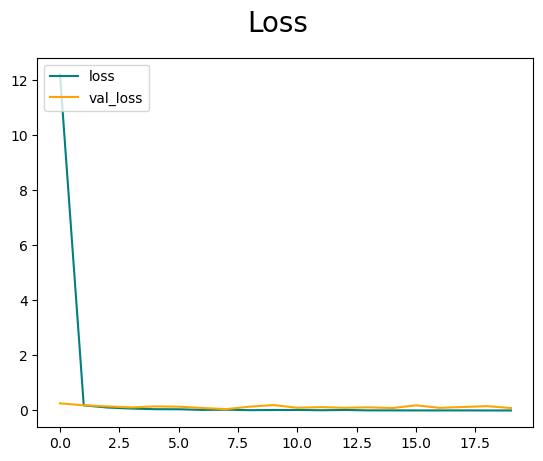

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

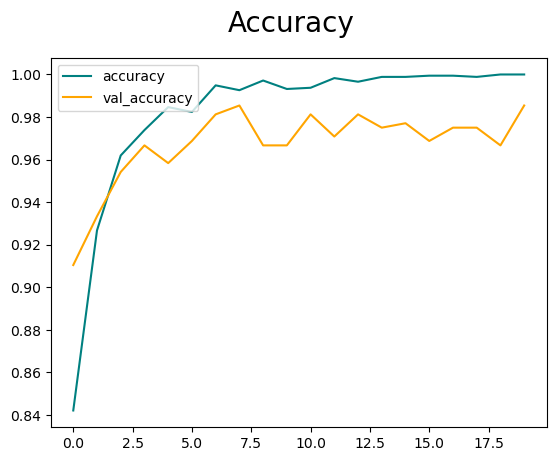

In [21]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [22]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [23]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 124ms/step


In [24]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.85714287, shape=(), dtype=float32) tf.Tensor(0.98214287, shape=(), dtype=float32)


# 10. Test

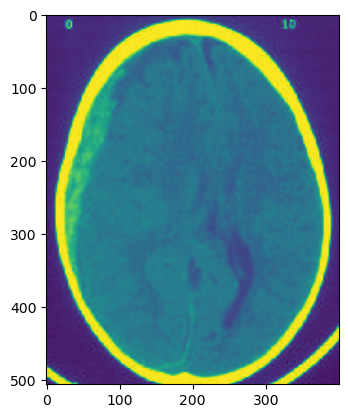

In [25]:
img = cv2.imread('stroketest.jpg',0)
plt.imshow(img)
plt.show()

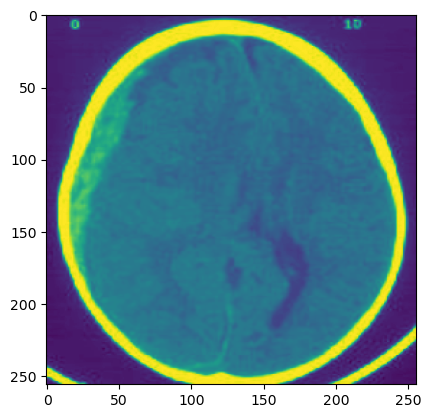

In [26]:
new_size = (256,256)
resize = cv2.resize(img, new_size)
plt.imshow(resize)
plt.show()

In [27]:
yhat = model.predict(np.expand_dims(resize,0))

1/1 [==============================] - 0s 69ms/step


In [28]:
yhat

array([[0.57613844]], dtype=float32)

In [29]:
if yhat > 0.5: 
    print(f'Predicted class is stroke')
else:
    print(f'Predicted class is normale')

Predicted class is stroke


# 11. Save the Model

In [30]:
model.save(os.path.join('models','imageclassifier.h5'))

In [31]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [32]:
img2 = cv2.imread('stroketest.jpg',0)
img2 = cv2.resize(img2, new_size)

In [33]:
yhatnew=new_model.predict(np.expand_dims(img2, 0))
yhatnew

1/1 [==============================] - 0s 65ms/step


array([[0.57613844]], dtype=float32)

In [34]:
if yhatnew > 0.5: 
    print(f'Predicted class is stroke')
else:
    print(f'Predicted class is normale')

Predicted class is stroke
